In [1]:
import rpy2
import sys
sys.path.append('/home/thies/repos/BIU/') # Modify this to where you have downloaded the BIU library
import biu
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['svg.fonttype'] = 'none'

import seaborn as sns
import scipy

R = biu.R()

# Load the questionnaire

In [2]:
Q = biu.formats.XLSX('data/F2Q.anonymised.xlsx')["Sheet1"].drop(columns=[0])
Q.columns = Q.iloc[0]
Q = Q.iloc[1:]

Q = Q[~Q['F2Q_00_13_00_00_v|External Data Reference'].isna()]

## Create sample identifiers

In [3]:
Q['participant'] = Q['F2Q_00_13_00_00_v|External Data Reference']
Q['timepoint']   = Q['F2Q_00_00_00_00_v|Timepoint']
Q['sample_id']   = Q.apply(lambda x: '_'.join(x[['participant', 'timepoint']]), axis=1)


## Check missing and duplicate responses from participants

### Duplicate/triplicate responses

Some participants have duplicate or triplicate responses to some questionnaires. So let's take the most complete reference (based on `F2Q_00_05_00_00_v|Progress`)

In [4]:
duplicate_responses = biu.ops.lst.qerf(Q.sample_id)
print("Duplicate sample_ids: ", duplicate_responses[2])
print("Triplicate sample_ids: ", duplicate_responses[3])

# Choose the most complete:
Q = Q[Q['F2Q_00_05_00_00_v|Progress'] == Q[['sample_id','F2Q_00_05_00_00_v|Progress']].groupby('sample_id').transform(lambda x: x.max())['F2Q_00_05_00_00_v|Progress']]

# And now if we still have duplicates, take the first completed:
Q = Q[Q['F2Q_00_02_00_00_v|End Date'] == Q[['sample_id','F2Q_00_02_00_00_v|End Date']].groupby('sample_id').transform(lambda x: x.min())['F2Q_00_02_00_00_v|End Date']]

Duplicate sample_ids:  ['ISALA03991_S4', 'ISALA00076_S4', 'ISALA00862_S4', 'ISALA03991_S5', 'ISALA00076_S5', 'ISALA03991_S6', 'ISALA00076_S6']
Triplicate sample_ids:  ['ISALA06028_S1']


### Check missing responses

<AxesSubplot:xlabel='participant', ylabel='timepoint'>

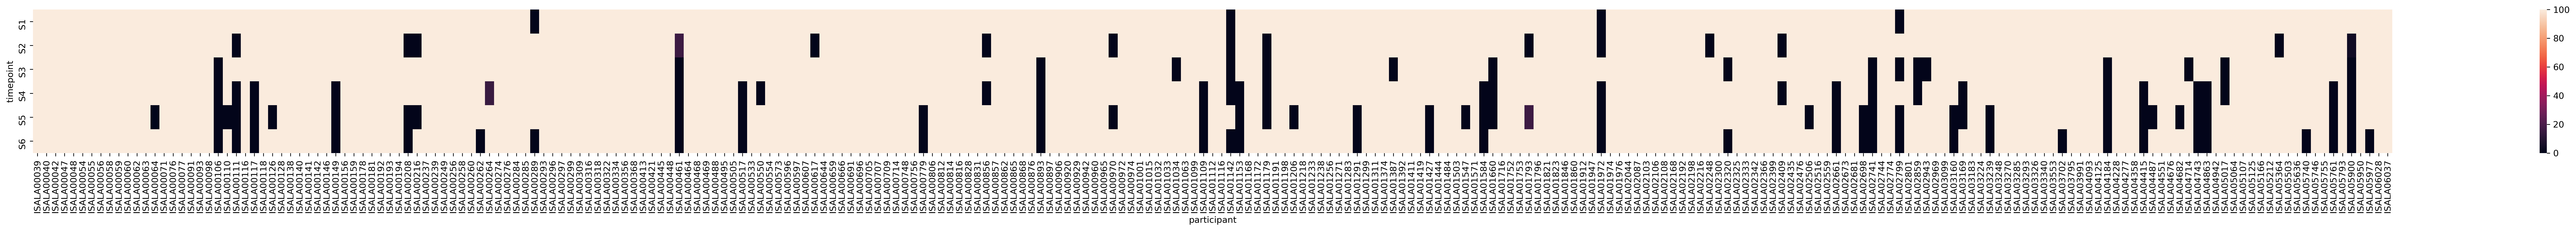

In [5]:
Q_missing = Q.pivot(index='participant', columns='timepoint', values='F2Q_00_05_00_00_v|Progress')
Q_missing = Q_missing.fillna(0)

fig, axes = biu.utils.figure.subplots(figsize=(60, 3))
sns.heatmap(Q_missing.transpose(), ax=axes[0])

# Clean questions

## Cleaned data frame

In [6]:
QC = Q[['sample_id', 'participant', 'timepoint']].copy()

In [7]:
sorted(Q.columns)

['F2Q_00_00_00_00_v|Timepoint',
 'F2Q_00_01_00_00_v|Start Date',
 'F2Q_00_02_00_00_v|End Date',
 'F2Q_00_03_00_00_v|Response Type',
 'F2Q_00_05_00_00_v|Progress',
 'F2Q_00_06_00_00_v|Duration (in seconds)',
 'F2Q_00_07_00_00_v|Finished',
 'F2Q_00_08_00_00_v|Recorded Date',
 'F2Q_00_09_00_00_v|Response ID',
 'F2Q_00_13_00_00_v|External Data Reference',
 'F2Q_00_16_00_00_v|Distribution Channel',
 'F2Q_00_17_00_00_v|User Language',
 'F2Q_01_02_00_00_v|Door COVID-19 en andere omstandigheden is het mogelijk dat je gewicht is gewijzigd en hierdoor vragen we om dit nogmaals in te vullen. Wat is je gewicht uitgedrukt in kg?',
 'F2Q_01_03_01_00_v|Is je seksuele relatiestatus recent gewijzigd?',
 'F2Q_01_03_02_00_v|Is je seksuele relatiestatus gewijzigd sinds de vorige staalname?',
 "F2Q_01_04_00_00_v|Heb je de afgelopen 24u zoveel gedronken waardoor je 's nachts moest opstaan om te plassen?",
 'F2Q_01_05_01_00_v|Hoeveel porties heb je van de onderstaande zaken gedronken in de afgelopen 48 uur (

## An example cleaned question: Stress

In [8]:
# column of question
c = 'F2Q_01_14_02_00_v|Voelde je je sinds de vorige staalname gemiddeld somberder en/of meer gestresseerd dan normaal?'

# All responses to this question:
print(biu.ops.lst.freq(Q[c]))

QC['Health.Mental.More_stress.week'] = Q[c].apply(lambda x: None if pd.isna(x) else x == 'Ja')
QC['Health.Mental.Less_stress.week'] = Q[c].apply(lambda x: None if pd.isna(x) else x == 'Minder dan eerder aangegeven')
QC['Health.Mental.Same_stress.week'] = Q[c].apply(lambda x: None if pd.isna(x) else x == 'Hetzelfde')

{None: 261, 'Hetzelfde': 863, 'Minder dan eerder aangegeven': 119, 'Ja': 187}


## Sex in last week

In [9]:
c = 'F2Q_01_15_00_00_v|Had je de afgelopen week seks? Hiermee bedoelen we allerlei vormen van stimulatie van de vagina, vulva, clitoris en anus, waaronder manuele, orale, vaginale en anale seks, masturbatie,…(al dan niet met vaginale penetratie)'

# All responses to this question:
print(biu.ops.lst.freq(Q[c]))

QC['Intimacy.Sex.week'] = Q[c].apply(lambda x: None if pd.isna(x) else x == 'Ja')

{'Nee': 380, 'Ja': 1046, None: 4}


In [10]:
## Different types of sex in last 24 hours

allC = [
    'F2Q_01_16_01_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Manuele seks',
    'F2Q_01_16_02_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Orale seks',
    'F2Q_01_16_03_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met vingers',
    'F2Q_01_16_04_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met penis',
    'F2Q_01_16_05_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met speeltjes',
    'F2Q_01_16_06_00_t|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Vaginale penetratie met andere: - tekst',
    'F2Q_01_16_06_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met andere:',
    'F2Q_01_16_08_00_t|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Andere: - tekst',
    'F2Q_01_16_08_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Andere:',
    'F2Q_01_16_11_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale seks zonder penetratie',
    'F2Q_01_16_12_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Anale seks',
    'F2Q_01_16_13_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Nee'
]

C = {
 "Intimacy.masturbation.24h"               : 'F2Q_01_16_01_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Manuele seks',
 "Intimacy.Oral.sex.24h"                   : 'F2Q_01_16_02_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Orale seks',
 "Intimacy.Vaginal.Penetration_finger.24h" : 'F2Q_01_16_03_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met vingers',
 "Intimacy.Vaginal.Penetration_penis.24h"  : 'F2Q_01_16_04_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met penis',
 "Intimacy.Vaginal.Penetration_toy.24h"    : 'F2Q_01_16_05_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale penetratie met speeltjes',
 "Intimacy.Vaginal.Nopenetration.24h"      : 'F2Q_01_16_11_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Vaginale seks zonder penetratie',
 "Intimacy.Anal.Penetration.24h"           : 'F2Q_01_16_12_00_v|Heb je de afgelopen 24 uur de volgende seksuele handelingen ontvangen of bij jezelf uitgevoerd (masturbatie)? (Meerdere antwoorden mogelijk) - Selected Choice - Anale seks',
}

background = 'F2Q_01_16|background'

Q[background] = Q[allC].isna().apply(all, axis=1)

for k, v in C.items():
    print(biu.ops.lst.freq(Q[v]))
    
    QC[k] = Q[[background, v]].apply(lambda r: None if r[0] else False if pd.isna(r[1]) else True, axis=1)
    print(biu.ops.lst.freq(QC[k]))
#efor
    

{None: 978, 'Manuele seks': 452}
{None: 384, True: 452, False: 594}
{None: 1265, 'Orale seks': 165}
{None: 384, True: 165, False: 881}
{None: 1179, 'Vaginale penetratie met vingers': 251}
{None: 384, False: 795, True: 251}
{None: 1092, 'Vaginale penetratie met penis': 338}
{None: 384, True: 338, False: 708}
{None: 1321, 'Vaginale penetratie met speeltjes': 109}
{None: 384, False: 937, True: 109}
{None: 1342, 'Vaginale seks zonder penetratie': 88}
{None: 384, False: 958, True: 88}
{None: 1418, 'Anale seks': 12}
{None: 384, False: 1034, True: 12}


## Menstrual hygiene products

In [11]:
allC = [
    'F2Q_01_20_01_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Tampon',
    'F2Q_01_20_02_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Maandverband',
    'F2Q_01_20_03_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Menstruatiecup',
    'F2Q_01_20_04_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Inlegkruisje',
    'F2Q_01_20_05_00_t|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Andere: - tekst',
    'F2Q_01_20_05_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Andere:',
    'F2Q_01_20_06_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Nee'
]

C = {
    'Hygiene.Vaginal.Tampon.48h' : 'F2Q_01_20_01_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Tampon',
    'Hygiene.Vaginal.Pad.48h' : 'F2Q_01_20_02_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Maandverband',
    'Hygiene.Vaginal.Cup.48h' : 'F2Q_01_20_03_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Menstruatiecup',
    'Hygiene.Vaginal.Pantyliner.48h' : 'F2Q_01_20_04_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Inlegkruisje',
}

other_c        = 'F2Q_01_20_05_00_t|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Andere: - tekst'
inlegkruis_c   = 'F2Q_01_20_04_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Inlegkruisje'
maandverband_c = 'F2Q_01_20_02_00_v|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Selected Choice - Maandverband'

inlegkruis_options = {
    'wasbaar maandverband en inlegkruisje',
    'nieuw soort inlegkruisje - zonder plastiek',
    'herbruikbaar inlegkruisje',
    'wasbaar inlegkruis'
                      }

maandverband_options = {
    'wasbaar maandverband en inlegkruisje',
    'Herbruikbaar maandverband',
    'herbruikbaar maandverband ondergoed (als extra bij de cup)',
    'Wasbaar maandverband ',
    'wasbaar maandverband',
}

Q[inlegkruis_c]   = Q[[other_c, inlegkruis_c]].apply(  lambda r: r[1] if r[0] is None else (None if r[0] not in inlegkruis_options   else r[0]) if pd.isna(r[1]) else r[1], axis=1)
Q[maandverband_c] = Q[[other_c, maandverband_c]].apply(lambda r: r[1] if r[0] is None else (None if r[0] not in maandverband_options else r[0]) if pd.isna(r[1]) else r[1], axis=1)

background = 'F2Q_01_20|background'

Q[background] = Q[allC].isna().apply(all, axis=1)

for k, v in C.items():
    QC[k] = Q[[background, v]].apply(lambda r: None if r[0] else False if pd.isna(r[1]) else True, axis=1)
    print(k, biu.ops.lst.freq(QC[k]))
#efor

Hygiene.Vaginal.Tampon.48h {False: 1326, True: 100, None: 4}
Hygiene.Vaginal.Pad.48h {True: 176, False: 1250, None: 4}
Hygiene.Vaginal.Cup.48h {False: 1348, True: 78, None: 4}
Hygiene.Vaginal.Pantyliner.48h {True: 402, False: 1024, None: 4}


In [12]:
biu.ops.lst.freq(Q['F2Q_01_20_05_00_t|Heb je de volgende producten de afgelopen 48 uur gebruikt? (Meerdere antwoorden mogelijk) - Andere: - tekst'])

{None: 1412,
 'Cheeky pants': 1,
 'wasbaar maandverband en inlegkruisje': 1,
 'Herbruikbaar maandverband': 1,
 'herbruikbaar maandverband ondergoed (als extra bij de cup)': 2,
 'menstruatieonderbroek': 1,
 'nieuw soort inlegkruisje - zonder plastiek': 1,
 'Tena': 1,
 'menstruatieondergoed': 1,
 'herbruikbaar inlegkruisje': 1,
 'Menstruatie-ondergoed': 1,
 'Wcpapier': 1,
 'menstruatieonderbroek Thinx': 1,
 'Wasbaar maandverband ': 1,
 'wasbaar inlegkruis': 1,
 'wasbaar maandverband': 1,
 'Menstruatieonderbroek': 1,
 'Vochtige intieme doekjes': 1}

In [13]:
allC = [
 'F2Q_01_21_01_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Roodheid',
 'F2Q_01_21_02_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Zwelling',
 'F2Q_01_21_03_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Pijn (algemeen)',
 'F2Q_01_21_04_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Jeuk',
 'F2Q_01_21_05_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Branderig gevoel',
 'F2Q_01_21_06_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Toename in vaginale afscheiding (anders dan de normale maandelijkse afscheiding)',
 'F2Q_01_21_07_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Verandering in de vaginale afscheiding (andere kleur, onaangename geur)',
 'F2Q_01_21_08_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Pijn tijdens seksueel contact',
 'F2Q_01_21_11_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Blaasontsteking',
 'F2Q_01_21_09_00_t|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Andere: - tekst',
 'F2Q_01_21_09_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Andere:',
 'F2Q_01_21_10_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Nee',
]

C = {
 "Health.Vaginal.Redness.week"               : 'F2Q_01_21_01_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Roodheid',
 "Health.Vaginal.Swelling.week"              : 'F2Q_01_21_02_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Zwelling',
 "Health.Vaginal.Pain.week"                  : 'F2Q_01_21_03_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Pijn (algemeen)',
 "Health.Vaginal.Itching.week"               : 'F2Q_01_21_04_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Jeuk',
 "Health.Vaginal.Burning.week"               : 'F2Q_01_21_05_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Branderig gevoel',
 "Health.Vaginal.Increased_secretions.week"  : 'F2Q_01_21_06_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Toename in vaginale afscheiding (anders dan de normale maandelijkse afscheiding)',
 "Health.Vaginal.Change_in_secretions.week"  : 'F2Q_01_21_07_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Verandering in de vaginale afscheiding (andere kleur, onaangename geur)',
 "Health.Vaginal.Pain_during_sex.week"       : 'F2Q_01_21_08_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Pijn tijdens seksueel contact',
 "Health.Vaginal.UrinaryTractInfection.week" : 'F2Q_01_21_11_00_v|Heb je de laatste week last gehad van één of meerdere klachten aan je vulva of vagina? (Meerdere antwoorden mogelijk) - Selected Choice - Blaasontsteking',
}

background = 'F2Q_01_21|background'

Q[background] = Q[allC].isna().apply(all, axis=1)

for k, v in C.items():
    QC[k] = Q[[background, v]].apply(lambda r: None if r[0] else False if pd.isna(r[1]) else True, axis=1)
    print(k, biu.ops.lst.freq(QC[k]))
#efor

Health.Vaginal.Redness.week {False: 1378, True: 48, None: 4}
Health.Vaginal.Swelling.week {False: 1398, True: 28, None: 4}
Health.Vaginal.Pain.week {False: 1370, True: 56, None: 4}
Health.Vaginal.Itching.week {False: 1244, True: 182, None: 4}
Health.Vaginal.Burning.week {False: 1339, True: 87, None: 4}
Health.Vaginal.Increased_secretions.week {False: 1342, True: 84, None: 4}
Health.Vaginal.Change_in_secretions.week {False: 1353, True: 73, None: 4}
Health.Vaginal.Pain_during_sex.week {False: 1378, True: 48, None: 4}
Health.Vaginal.UrinaryTractInfection.week {False: 1407, True: 19, None: 4}


# Export cleaned questionnaire

In [14]:
QC.to_pickle('data/cleaned/F2Q.anonymised.cleaned.pkl')
QC.to_excel('data/cleaned/F2Q.anonymised.cleaned.xlsx', index=False)

In [15]:
QC

,sample_id,participant,timepoint,Health.Mental.More_stress.week,Health.Mental.Less_stress.week,Health.Mental.Same_stress.week,Intimacy.Sex.week,Intimacy.masturbation.24h,Intimacy.Oral.sex.24h,Intimacy.Vaginal.Penetration_finger.24h,...,Hygiene.Vaginal.Pantyliner.48h,Health.Vaginal.Redness.week,Health.Vaginal.Swelling.week,Health.Vaginal.Pain.week,Health.Vaginal.Itching.week,Health.Vaginal.Burning.week,Health.Vaginal.Increased_secretions.week,Health.Vaginal.Change_in_secretions.week,Health.Vaginal.Pain_during_sex.week,Health.Vaginal.UrinaryTractInfection.week
8,ISALA00972_S1,ISALA00972,S1,None,None,None,False,None,None,None,...,True,False,False,False,False,False,False,False,False,False
9,ISALA06037_S1,ISALA06037,S1,None,None,None,False,None,None,None,...,False,False,False,False,False,False,False,False,False,False
10,ISALA00368_S1,ISALA00368,S1,None,None,None,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
11,ISALA00714_S1,ISALA00714,S1,None,None,None,True,False,False,False,...,False,False,False,False,False,False,False,True,True,False
12,ISALA05746_S1,ISALA05746,S1,None,None,None,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,ISALA01484_S6,ISALA01484,S6,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1468,ISALA00469_S6,ISALA00469,S6,False,False,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1469,ISALA05503_S6,ISALA05503,S6,False,False,True,False,None,None,None,...,False,False,False,False,False,False,False,True,False,False
1470,ISALA01660_S6,ISALA01660,S6,False,False,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
